In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import time

2025-04-19 07:33:51.993024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745048032.182012      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745048032.238794      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from glob import glob

BASE_DIR = '/kaggle/input/image-watermarking-datasetcover-mark/dataset'

TRAIN_COVER_DIR = os.path.join(BASE_DIR, "train", "cover")
TRAIN_MARK_DIR = os.path.join(BASE_DIR, "train", "mark")
TEST_COVER_DIR = os.path.join(BASE_DIR, "test", "cover")
TEST_MARK_DIR = os.path.join(BASE_DIR, "test", "mark")

train_cover_paths = [str(p) for p in sorted(glob(f"{TRAIN_COVER_DIR}/*.JPEG"))]
train_mark_paths = [str(p) for p in sorted(glob(f"{TRAIN_MARK_DIR}/*.png"))]
test_cover_paths = [str(p) for p in sorted(glob(f"{TEST_COVER_DIR}/*.JPEG"))]
test_mark_paths = [str(p) for p in sorted(glob(f"{TEST_MARK_DIR}/*.png"))]



In [4]:
def load_image_pair(cover_path, mark_path):
    cover = tf.io.read_file(cover_path)
    cover = tf.image.decode_jpeg(cover, channels=3)
    cover = tf.image.resize(cover, [128, 128])
    cover = tf.cast(cover, tf.float32) / 255.0

    mark = tf.io.read_file(mark_path)
    mark = tf.image.decode_png(mark, channels=3)
    mark = tf.image.resize(mark, [128, 128])
    mark = tf.cast(mark, tf.float32) / 255.0

    return cover, mark

def create_dataset(cover_paths, mark_paths):
    # Convert to tf.string tensors explicitly
    cover_paths = tf.constant(cover_paths, dtype=tf.string)
    mark_paths = tf.constant(mark_paths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((cover_paths, mark_paths))
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset



In [5]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


In [6]:
# Create datasets
train_ds = create_dataset(train_cover_paths, train_mark_paths)
test_ds = create_dataset(test_cover_paths, test_mark_paths)

# Prepare them for training
train_ds = prepare_for_training(train_ds)
test_ds = prepare_for_training(test_ds)


I0000 00:00:1745048069.073247      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
for input_tensor, label_tensor in train_ds.take(1):
    print("Input Tensor Type:", type(input_tensor))
    print("Label Tensor Type:", type(label_tensor))
    print("Input Tensor Shape:", input_tensor.shape)
    print("Label Tensor Shape:", label_tensor.shape)

    input_image = input_tensor[0].numpy()
    label_image = label_tensor[0].numpy()

    print("Input Image min/max:", input_image.min(), input_image.max())
    print("Label Image min/max:", label_image.min(), label_image.max())

Input Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Input Tensor Shape: (32, 128, 128, 3)
Label Tensor Shape: (32, 128, 128, 3)
Input Image min/max: 0.0 1.0
Label Image min/max: 0.0 1.0


Input image shape: (128, 128, 3)
Watermark image shape: (128, 128, 3)


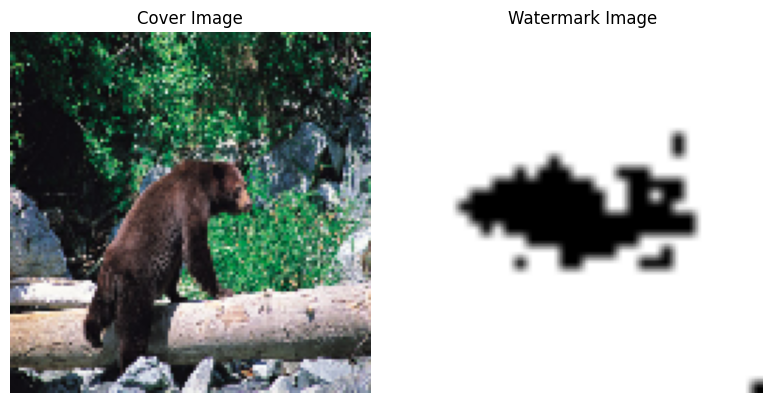

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Take one batch from dataset
for input_tensor, label_tensor in train_ds.take(1):
    input_image = input_tensor[0].numpy()
    label_image = label_tensor[0].numpy()

    print("Input image shape:", input_image.shape)
    print("Watermark image shape:", label_image.shape)

    # Show images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Cover Image")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Watermark Image")
    plt.imshow(label_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [32]:
#Preparing dataset for embedding (Training and Testing)
def prepare_data_for_embedding(cover_paths, mark_paths, size=(64, 64), alpha=0.3):
    input_list, output_list = [], []
    for c_path, m_path in zip(cover_paths, mark_paths):
        cover = Image.open(c_path).convert("L").resize(size)
        mark = Image.open(m_path).convert("L").resize(size)

        cover_arr = np.array(cover, dtype=np.float32).flatten() / 255.0
        mark_arr = np.array(mark, dtype=np.float32).flatten() / 255.0

        input_vector = np.hstack([cover_arr, mark_arr]) 
        blended = (1 - alpha) * cover_arr + alpha * mark_arr 

        input_list.append(input_vector)
        output_list.append(blended)

    return np.array(input_list), np.array(output_list)

# Used 5000 images for training and 2000 images for testing - SVM and GBM
X_train_raw, y_train_raw = prepare_data_for_embedding(train_cover_paths[:5000], train_mark_paths[:5000])
X_test_raw, y_test_raw = prepare_data_for_embedding(test_cover_paths[:1000], test_mark_paths[:1000])



In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Step 2: Reduce dimensions using PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#Step 3: Scale output features
output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train_raw)
y_test_scaled = output_scaler.transform(y_test_raw)

#Step 4: Reduce dimenions uing PCA
output_pca = PCA(n_components=50)
y_train_pca = output_pca.fit_transform(y_train_scaled)
y_test_pca = output_pca.transform(y_test_scaled)



### Machine Learning Models Implementation

### SVM - Training, Evaluation and Testing (Visualization)

In [34]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import time

start = time.time()

svm_model = LinearSVR(C=0.3, epsilon=0.1, max_iter=30000, tol=1e-2)
svm_ml = MultiOutputRegressor(svm_model)

# Train
svm_ml.fit(X_train_pca, y_train_pca)


svm_time = time.time() - start
print(f"SVM trained in {svm_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

SVM trained in 336.13 seconds


In [35]:
import joblib
#Step 1: Predict on test set (PCA-reduced)
y_pred_pca = svm_ml.predict(X_test_pca)

#Step 2: Inverse PCA on output
y_pred_scaled = output_pca.inverse_transform(y_pred_pca)

#Step 3: Inverse scaling to get back blended image
y_pred = output_scaler.inverse_transform(y_pred_scaled)

#Step 4: Inverse transform ground truth test labels for comparison
y_test_true_scaled = output_pca.inverse_transform(y_test_pca)
y_test_true = output_scaler.inverse_transform(y_test_true_scaled)

# Step 5: Evaluate
svm_mse = mean_squared_error(y_test_true.flatten(), y_pred.flatten())
svm_psnr = 10 * np.log10(1.0 / svm_mse)

print(f"SVM MSE: {svm_mse:.4f} | PSNR: {svm_psnr:.2f} dB")

# Step 6: Save model and transformers
joblib.dump(svm_ml, "svm_model.pkl")
joblib.dump(pca, "pca_x.pkl")
joblib.dump(output_pca, "pca_y.pkl")
joblib.dump(scaler, "scaler_x.pkl")
joblib.dump(output_scaler, "scaler_y.pkl")


SVM MSE: 0.0035 | PSNR: 24.54 dB


['scaler_y.pkl']

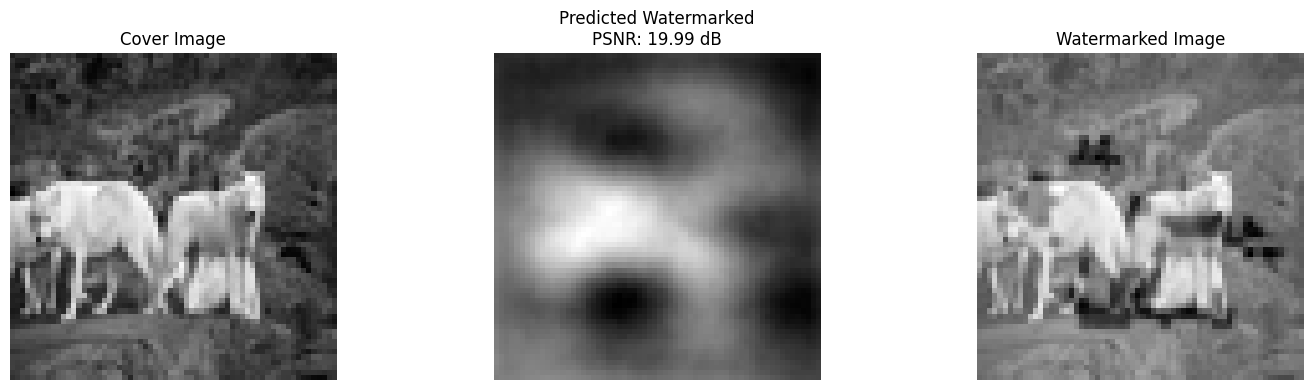

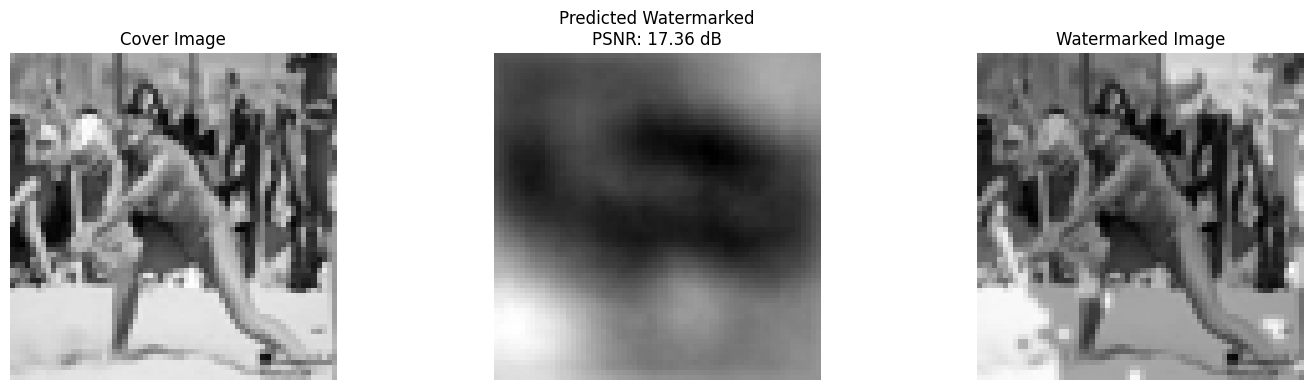

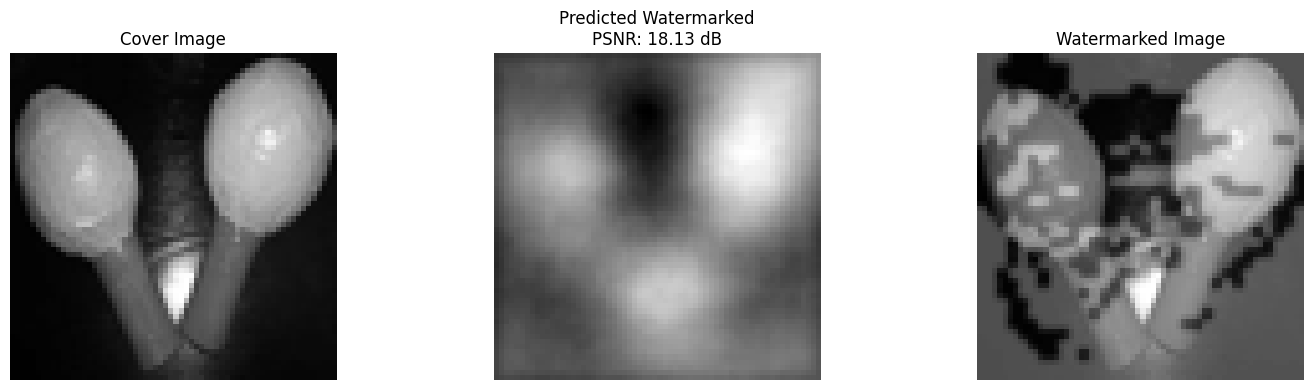

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from PIL import Image
import numpy as np
import random

def visualize_svm_embedding(sample_index=0, size=(64, 64), alpha=0.3):
    # Load cover and watermark from original paths
    cover = Image.open(test_cover_paths[sample_index]).convert("L").resize(size)
    mark = Image.open(test_mark_paths[sample_index]).convert("L").resize(size)

    # Convert to arrays and normalize
    cover_arr = np.array(cover, dtype=np.float32) / 255.0
    mark_arr = np.array(mark, dtype=np.float32) / 255.0

    # Ground truth blended image
    true_blended = (1 - alpha) * cover_arr + alpha * mark_arr

    # Prepare input vector (flattened cover + mark)
    input_vector = np.hstack([cover_arr.flatten(), mark_arr.flatten()])

    # Apply scaling and PCA (same pipeline as training)
    input_vector_scaled = scaler.transform([input_vector])
    input_vector_pca = pca.transform(input_vector_scaled)

    # Predict using trained SVM model
    pred_pca = svm_ml.predict(input_vector_pca)

    # Inverse PCA and scaling on prediction
    pred_scaled = output_pca.inverse_transform(pred_pca)
    pred_image_flat = output_scaler.inverse_transform(pred_scaled)

    # Reshape to image
    predicted_blended = pred_image_flat.reshape(size)
    predicted_blended = np.clip(predicted_blended, 0, 1)

    # Compute MSE and PSNR
    mse = mean_squared_error(true_blended.flatten(), predicted_blended.flatten())
    psnr = 10 * np.log10(1.0 / mse)

    # Plotting
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cover_arr, cmap='gray')
    plt.title("Cover Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_blended, cmap='gray')
    plt.title(f"Predicted Watermarked\nPSNR: {psnr:.2f} dB")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_blended, cmap='gray')
    plt.title("Watermarked Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#Show 3 random predictions
for sample_index in random.sample(range(len(test_cover_paths)), 3):
    visualize_svm_embedding(sample_index)


### GBM - Training, Evaluation and Testing (Evaluation )

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import time

start = time.time()

gbm_model = MultiOutputRegressor(GradientBoostingRegressor())
gbm_model.fit(X_train_pca, y_train_pca)

gbm_time = time.time() - start
print(f"GBM trained in {gbm_time:.2f} seconds")


GBM trained in 396.20 seconds


In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

# Predict in PCA-compressed space
gbm_pred_pca = gbm_model.predict(X_test_pca)

# Inverse PCA and scaler transforms
gbm_pred_scaled = output_pca.inverse_transform(gbm_pred_pca)
gbm_pred = output_scaler.inverse_transform(gbm_pred_scaled)

# Inverse transform y_test for ground truth
y_test_true_scaled = output_pca.inverse_transform(y_test_pca)
y_test_true = output_scaler.inverse_transform(y_test_true_scaled)

# Evaluate
gbm_mse = mean_squared_error(y_test_true.flatten(), gbm_pred.flatten())
gbm_psnr = 10 * np.log10(1.0 / gbm_mse)

print(f"GBM MSE: {gbm_mse:.4f} | PSNR: {gbm_psnr:.2f} dB")

GBM MSE: 0.0046 | PSNR: 23.41 dB


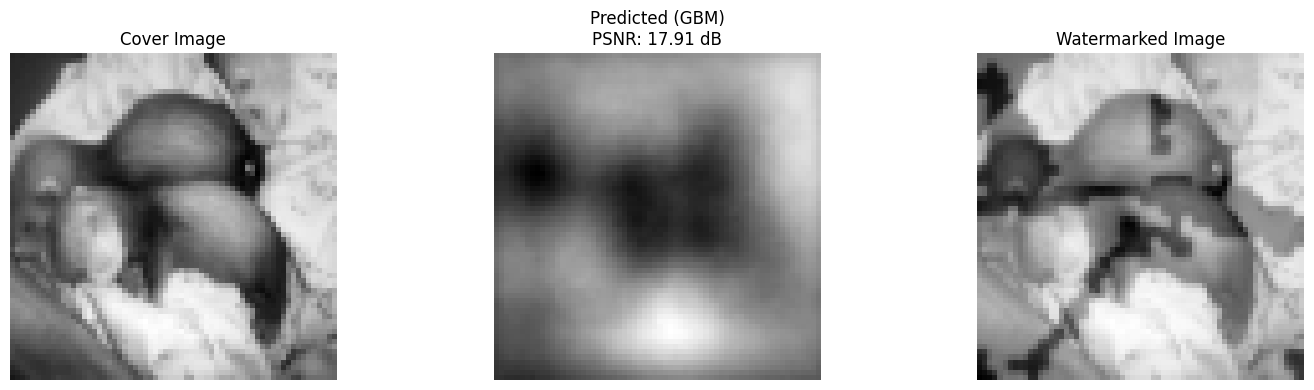

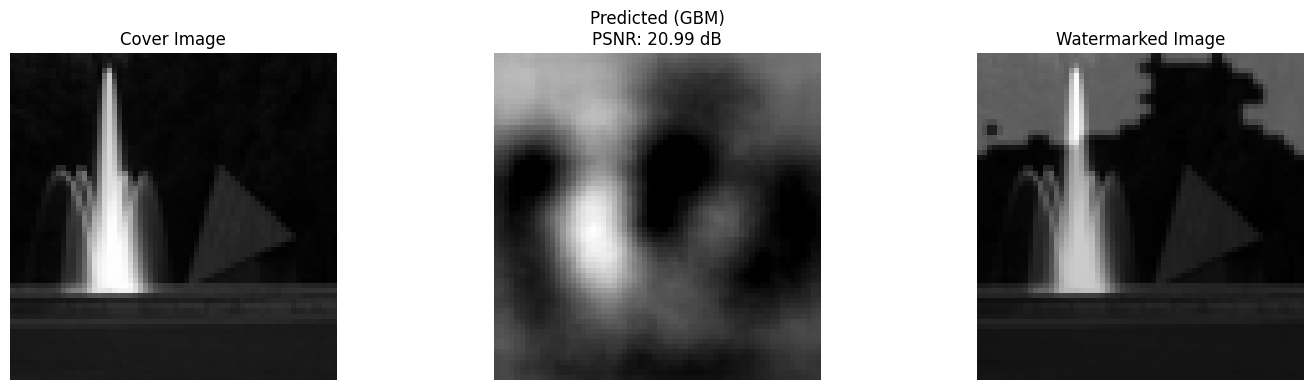

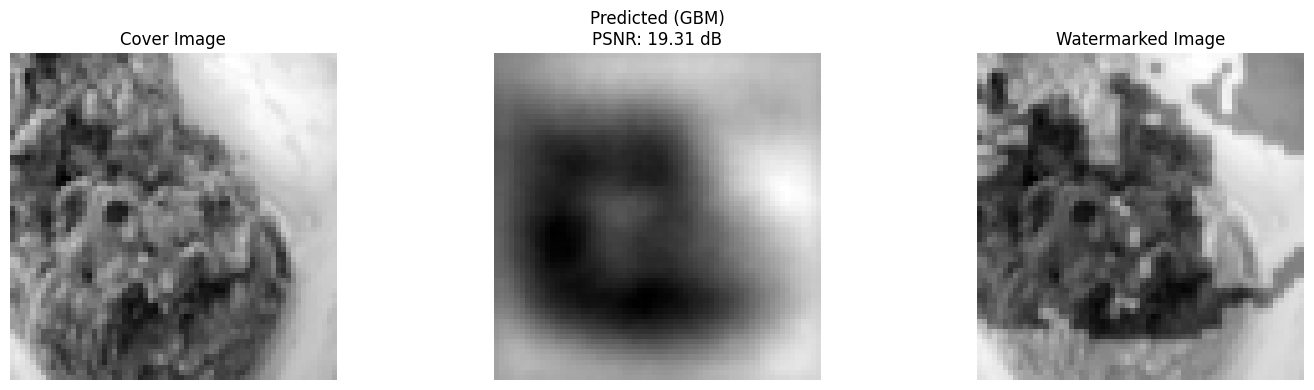

In [44]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import mean_squared_error
import random

def visualize_gbm_embedding(sample_index=0, size=(64, 64), alpha=0.3):
    # Load original cover and watermark images
    cover = Image.open(test_cover_paths[sample_index]).convert("L").resize(size)
    mark = Image.open(test_mark_paths[sample_index]).convert("L").resize(size)

    # Normalize image arrays
    cover_arr = np.array(cover, dtype=np.float32) / 255.0
    mark_arr = np.array(mark, dtype=np.float32) / 255.0

    # Ground truth blended image
    true_blended = (1 - alpha) * cover_arr + alpha * mark_arr

    # Flatten input for prediction
    input_vector = np.hstack([cover_arr.flatten(), mark_arr.flatten()])

    # Apply input scaling and PCA
    input_scaled = scaler.transform([input_vector])
    input_pca = pca.transform(input_scaled)

    # Predict using GBM model
    pred_pca = gbm_model.predict(input_pca)

    # Inverse transform the predicted output
    pred_scaled = output_pca.inverse_transform(pred_pca)
    pred_img_flat = output_scaler.inverse_transform(pred_scaled)

    # Reshape to 2D image
    predicted_blended = pred_img_flat.reshape(size)
    predicted_blended = np.clip(predicted_blended, 0, 1)

    # Calculate metrics
    mse = mean_squared_error(true_blended.flatten(), predicted_blended.flatten())
    psnr = 10 * np.log10(1.0 / mse)

    # Plotting
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cover_arr, cmap='gray')
    plt.title("Cover Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_blended, cmap='gray')
    plt.title(f"Predicted (GBM)\nPSNR: {psnr:.2f} dB")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_blended, cmap='gray')
    plt.title("Watermarked Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

for sample_index in random.sample(range(len(test_cover_paths)), 3):
    visualize_gbm_embedding(sample_index)


In [45]:
#Model comparison summary - SVM and GBM
print("\n🔍 Model Comparison Summary")
print(f"SVM ➤ MSE: {svm_mse:.4f} | PSNR: {svm_psnr:.2f} dB")
print(f"GBM ➤ MSE: {gbm_mse:.4f} | PSNR: {gbm_psnr:.2f} dB")



🔍 Model Comparison Summary
SVM ➤ MSE: 0.0035 | PSNR: 24.54 dB
GBM ➤ MSE: 0.0046 | PSNR: 23.41 dB


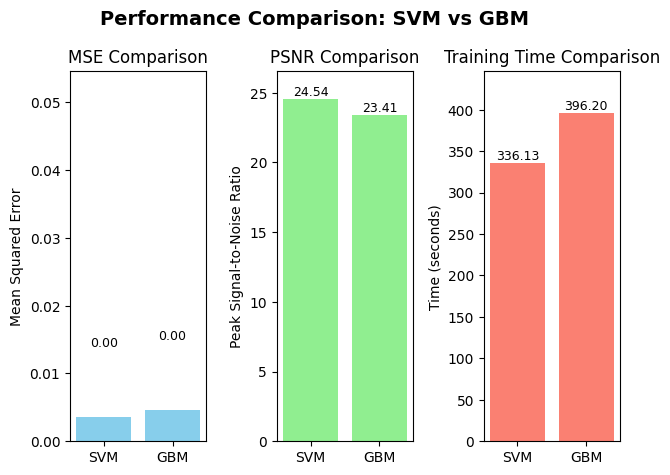

In [46]:
#Performance comparison of SVM and GBM
import matplotlib.pyplot as plt


#Performance metrics
mlmodels = ['SVM', 'GBM']
mse_values = [svm_mse, gbm_mse]
psnr_values = [svm_psnr, gbm_psnr]
time_values = [svm_time, gbm_time]

#For adding labels on top of each bars
def add_labels(values):
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)


#Performance metrics
# MSE
plt.subplot(1, 3, 1)
plt.bar(mlmodels, mse_values, color='skyblue')
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.ylim(0, max(mse_values) + 0.05)
add_labels(mse_values)

# PSNR
plt.subplot(1, 3, 2)
plt.bar(mlmodels, psnr_values, color='lightgreen')
plt.title('PSNR Comparison')
plt.ylabel('Peak Signal-to-Noise Ratio')
plt.ylim(0, max(psnr_values) + 2)
add_labels(psnr_values)

# Time
plt.subplot(1, 3, 3)
plt.bar(mlmodels, time_values, color='salmon')
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.ylim(0, max(time_values) + 50)
add_labels(time_values)

plt.suptitle('Performance Comparison: SVM vs GBM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [51]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Choose a sample
sample_idx = 0

# Step 1: Reconstruct true image
true_scaled = output_pca.inverse_transform(y_test_pca[sample_idx])
true_img_flat = output_scaler.inverse_transform([true_scaled])[0]
true_img = true_img_flat.reshape(64, 64)

# Step 2: Use final predicted image from SVM and GBM (already inverse-transformed)
svm_img = y_pred[sample_idx].reshape(64, 64)
gbm_img = gbm_pred[sample_idx].reshape(64, 64)

# Step 3: Compute SSIM
ssim_svm = ssim(true_img, svm_img, data_range=1.0)
ssim_gbm = ssim(true_img, gbm_img, data_range=1.0)

# Step 4: Display SSIM results
print(f"SSIM (SVM): {ssim_svm:.4f}")
print(f"SSIM (GBM): {ssim_gbm:.4f}")


SSIM (SVM): 0.8049
SSIM (GBM): 0.8100


In [53]:
import pandas as pd
# Step 1: Reconstruct full-size ground truth from PCA
y_test_full = output_pca.inverse_transform(y_test_pca)

# Step 2: Compute per-pixel squared errors
errors_svm = ((y_test_full - y_pred) ** 2).flatten()
errors_gbm = ((y_test_full - gbm_pred) ** 2).flatten()

# Step 3: Build dynamic metrics table
metrics_table = pd.DataFrame({
    "Model": ["SVM", "GBM"],
    "MSE": [round(svm_mse, 4), round(gbm_mse, 4)],
    "PSNR": [round(svm_psnr, 2), round(gbm_psnr, 2)],
    "Train Time (s)": [round(svm_time, 2), round(gbm_time, 2)],
    "SSIM": [round(ssim_svm, 4), round(ssim_gbm, 4)],
    "Median Error": [round(np.median(errors_svm), 4), round(np.median(errors_gbm), 4)],
    "Error Variance": [round(np.var(errors_svm), 4), round(np.var(errors_gbm), 4)]
})

metrics_table.set_index("Model", inplace=True)

# Step 4: Display the table
metrics_table



,MSE,PSNR,Train Time (s),SSIM,Median Error,Error Variance
Model,,,,,,
SVM,0.0035,24.54,336.13,0.8049,0.3528,0.7353
GBM,0.0046,23.41,396.20,0.8100,0.3610,0.7768


###  Deep Learning Models Implementation

In [54]:
def dldecode_image(img):
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [64, 64])  # You chose 64x64 for DL
    return img

def dlprocess_image_pair(cover_path, mark_path, alpha=0.3):
    # Decode + resize
    cover_img = dldecode_image(tf.io.read_file(cover_path))  # (64, 64, 1)
    mark_img = dldecode_image(tf.io.read_file(mark_path))    # (64, 64, 1)

    # Input = stacked channels
    input_img = tf.concat([cover_img, mark_img], axis=-1)  # (64, 64, 2)

    # Label = blended image
    blended_img = (1 - alpha) * cover_img + alpha * mark_img  # (64, 64, 1)

    return input_img, blended_img

def dlcreate_dataset(cover_paths, mark_paths, alpha=0.3):
    cover_ds = tf.data.Dataset.from_tensor_slices(cover_paths)
    mark_ds = tf.data.Dataset.from_tensor_slices(mark_paths)

    ds = tf.data.Dataset.zip((cover_ds, mark_ds))
    ds = ds.map(lambda c, m: dlprocess_image_pair(c, m, alpha), num_parallel_calls=tf.data.AUTOTUNE)
    return ds

def dlprepare_for_training(ds, batch_size=32):
    return ds.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [55]:
#Rebuild the dataset for Deep Learning Models
train_cover_paths = [str(p) for p in sorted(glob(f"{TRAIN_COVER_DIR}/*.JPEG"))]
train_mark_paths = [str(p) for p in sorted(glob(f"{TRAIN_MARK_DIR}/*.png"))]
test_cover_paths = [str(p) for p in sorted(glob(f"{TEST_COVER_DIR}/*.JPEG"))]
test_mark_paths = [str(p) for p in sorted(glob(f"{TEST_MARK_DIR}/*.png"))]

# Rebuild the image dataset pipeline for CNN, Xception and GAN
train_image_ds = dlprepare_for_training(dlcreate_dataset(train_cover_paths, train_mark_paths))
test_image_ds = dlprepare_for_training(dlcreate_dataset(test_cover_paths, test_mark_paths))



In [56]:
#CNN Model
import tensorflow as tf
from tensorflow.keras import layers, models

def get_cnn_model(input_shape=(64, 64, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        # Output layer
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  
    ])
    return model
cnn_model = get_cnn_model()

cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train the model
history = cnn_model.fit(train_image_ds,epochs=10,validation_data=test_image_ds)

Epoch 1/10


I0000 00:00:1745051654.876224      89 service.cc:148] XLA service 0x78ed00085ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745051654.877150      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745051655.165746      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0556 - mae: 0.1941 

I0000 00:00:1745051657.574974      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 129ms/step - loss: 0.0093 - mae: 0.0626 - val_loss: 0.0027 - val_mae: 0.0373
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0021 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0268
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0016 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0252
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0012 - val_mae: 0.0227
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - mae: 0.0234 - val_loss: 0.0010 - val_mae: 0.0216
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0011 - mae: 0.0220 - val_loss: 9.6406e-04 - val_mae: 0.0210
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.6360e-04 - mae: 0.0211 - val_loss: 9.2520e-04 - val_mae: 0.0208
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.9224e-04 - mae: 0.0204 - val_loss: 8.6419e-04 - val_mae: 0.0200
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7

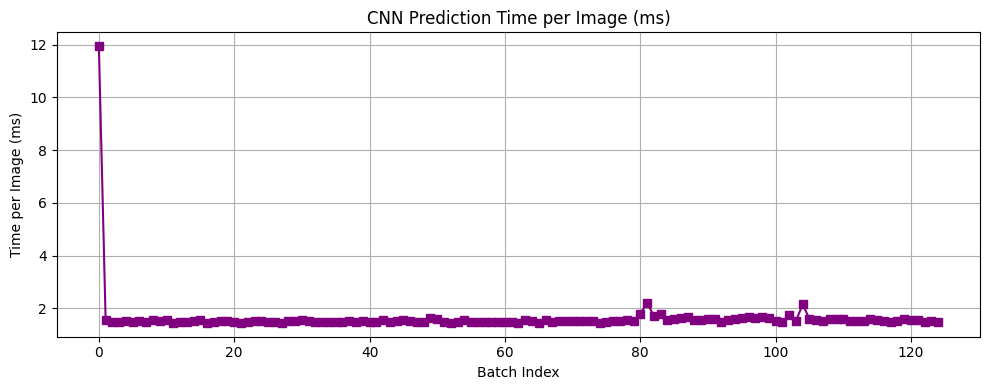

✅ CNN MSE: 0.0008 | PSNR: 32.28 dB


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Step 1: Measure prediction time per batch
prediction_times = []
mse_list, psnr_list = [], []

for inputs, targets in test_image_ds:
    start_time = time.time()
    preds = cnn_model.predict(inputs, verbose=0)
    elapsed = time.time() - start_time
    prediction_times.append(elapsed)

    preds = np.clip(preds, 0, 1)

    for i in range(preds.shape[0]):
        true = targets[i].numpy().flatten()
        pred = preds[i].flatten()

        mse = np.mean((true - pred) ** 2)
        psnr = 10 * np.log10(1.0 / mse)

        mse_list.append(mse)
        psnr_list.append(psnr)

# Step 2: Calculate averages
cnn_mse = np.mean(mse_list)
cnn_psnr = np.mean(psnr_list)

# Step 3: Plot prediction time per image (ms)
images_per_batch = 32
prediction_times_ms = [(t / images_per_batch) * 1000 for t in prediction_times]
batch_indices = list(range(len(prediction_times)))

plt.figure(figsize=(10, 4))
plt.plot(batch_indices, prediction_times_ms, marker='s', color='purple')
plt.title("CNN Prediction Time per Image (ms)")
plt.xlabel("Batch Index")
plt.ylabel("Time per Image (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Print & save model
print(f"✅ CNN MSE: {cnn_mse:.4f} | PSNR: {cnn_psnr:.2f} dB")
cnn_model.save("cnn_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


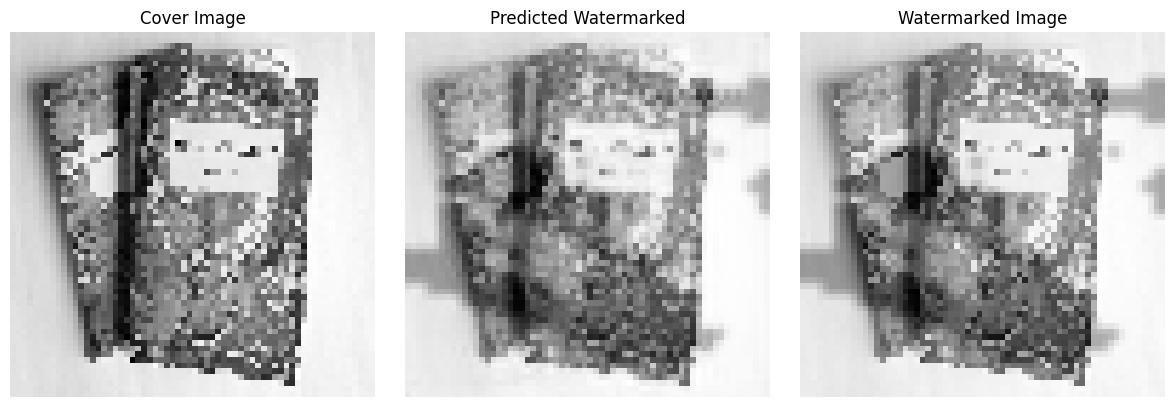

In [58]:
import matplotlib.pyplot as plt

def visualize_cnn_prediction(model, dataset, index=0):
    for inputs, targets in dataset.take(1):
        input_sample = inputs[index]
        target_sample = targets[index]

        pred = model.predict(tf.expand_dims(input_sample, axis=0))[0]

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(input_sample[..., 0], cmap='gray')
        plt.title("Cover Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred[..., 0], cmap='gray')
        plt.title("Predicted Watermarked")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(target_sample[..., 0], cmap='gray')
        plt.title("Watermarked Image")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

visualize_cnn_prediction(cnn_model, test_image_ds, index=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

CNN Eval — MSE: 0.0010, PSNR: 30.20, SSIM: 0.9722


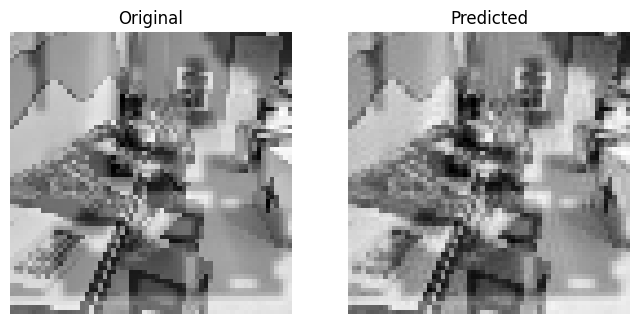

In [59]:
#Evaluation for CNN model
for cover, mark in test_image_ds.take(1):
    prediction = cnn_model.predict(cover)
    pred = prediction[0].squeeze()
    mse = mean_squared_error(mark[0].numpy().flatten(), pred.flatten())
    psnr = 10 * np.log10(1.0 / mse)
    ssim_score = ssim(mark[0].numpy().squeeze(), pred,data_range=1.0)
    print(f"\nCNN Eval — MSE: {mse:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim_score:.4f}")

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(mark[0].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted")
    plt.axis('off')
    plt.show()


In [60]:
#Xception model
base_model = tf.keras.applications.Xception(include_top=False, input_shape=(71, 71, 3), pooling='avg')
base_model.trainable = False
xception_model = tf.keras.Sequential([
    base_model,
    layers.Dense(1024, activation='relu'),
    layers.Dense(71 * 71, activation='sigmoid'),
    layers.Reshape((71, 71, 1))
])
xception_model.compile(optimizer='adam', loss='mse')
train_ds_x = train_image_ds.map(lambda x, y: (tf.image.resize(tf.image.grayscale_to_rgb(x[..., :1]), [71, 71]),tf.image.resize(y, [71, 71])))

test_ds_x = test_image_ds.map(lambda x, y: (tf.image.resize(tf.image.grayscale_to_rgb(x[..., :1]), [71, 71]),tf.image.resize(y, [71, 71])))

start = time.time()
xception_model.fit(train_ds_x, epochs=5, validation_data=test_ds_x)
xception_time = time.time() - start
print(f"Xception trained in {xception_time:.2f} seconds")
xception_model.save("xception_model.h5")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0485 - val_loss: 0.0458
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0444 - val_loss: 0.0454
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0427 - val_loss: 0.0460
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0410 - val_loss: 0.0463
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0393 - val_loss: 0.0464
Xception trained in 62.76 seconds


In [65]:
#Evaluation of the Model
for cover, mark in test_image_ds.take(1):
    # Resize and convert cover image to RGB
    cover_img = cover[..., :1]
    rgb_cover = tf.image.resize(tf.image.grayscale_to_rgb(cover_img), [71, 71])
    if len(rgb_cover.shape) == 3:
        rgb_cover = tf.expand_dims(rgb_cover, axis=0)  

    # Predict with Xception model
    prediction = xception_model.predict(rgb_cover, verbose=0)
    pred = prediction[0].squeeze()

    # Resize ground truth to match predicted size
    true = tf.image.resize(mark[0], [71, 71]).numpy().squeeze()


    # Compute metrics
    mse = mean_squared_error(true.flatten(), pred.flatten())
    psnr = 10 * np.log10(1.0 / mse)
    ssim_score = ssim(true, pred, data_range=1.0)

    # Print metrics
    print(f"Xception Eval — MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_score:.4f}")


Xception Eval — MSE: 0.0569, PSNR: 12.45 dB, SSIM: 0.1161


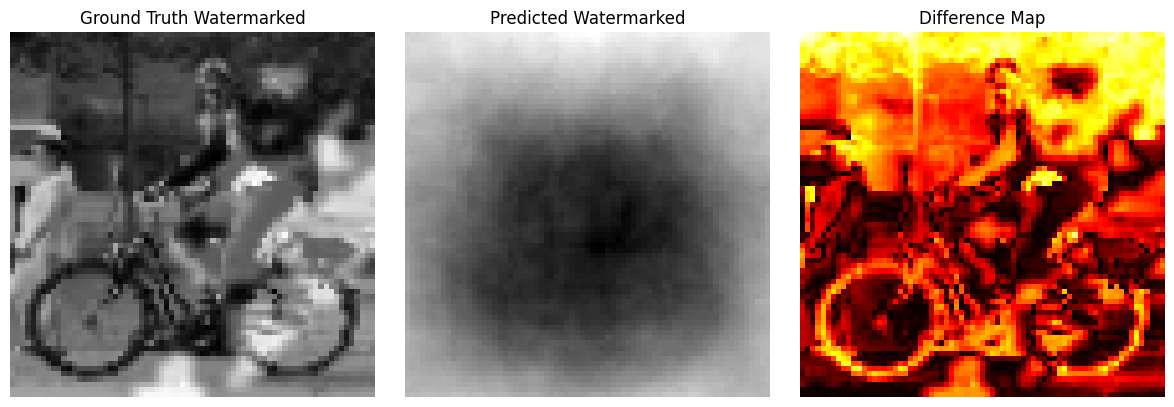

In [81]:
import matplotlib.pyplot as plt

# Make sure true and pred are both (64, 64) images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(true, cmap='gray')
plt.title("Ground Truth Watermarked")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Watermarked")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(true - pred), cmap='hot')  # Show error map
plt.title("Difference Map")
plt.axis('off')

plt.tight_layout()
plt.show()


In [69]:
#GAN Model
from tensorflow.keras import Model, Input
from sklearn.utils import shuffle

#Defining Generator
def build_generator(input_shape=(64, 64, 2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
    return models.Model(inputs, x, name="cgan_generator")


In [70]:
#defining discriminator
def build_discriminator():
    cover_input = layers.Input(shape=(64, 64, 2))       
    output_img = layers.Input(shape=(64, 64, 1))        

    x = layers.Concatenate()([cover_input, output_img]) 
    x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model([cover_input, output_img], x, name="cgan_discriminator")

In [71]:
#Compile and connect the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN
discriminator.trainable = False
input_pair = Input(shape=(64, 64, 2))
generated_blend = generator(input_pair)
gan_output = discriminator([input_pair, generated_blend])
gan = models.Model(input_pair, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')


In [72]:
#Train Conditional GAN
import numpy as np

EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for input_pair, real_blend in train_image_ds.take(100): 
        batch_size = input_pair.shape[0]
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Generate fake blend
        fake_blend = generator.predict(input_pair, verbose=0)

        # Train Discriminator
        discriminator.trainable = True
        discriminator.train_on_batch([input_pair, real_blend], real_labels)
        discriminator.train_on_batch([input_pair, fake_blend], fake_labels)

        # Train Generator (via GAN)
        discriminator.trainable = False
        gan.train_on_batch(input_pair, real_labels)



Epoch 1/5

Epoch 2/5

Epoch 3/5

Epoch 4/5

Epoch 5/5


In [82]:
# Visual representation for cGAN
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

for cover_mark, real_blend in test_image_ds.take(1):
    # Generate fake watermarked image using the cGAN generator
    fake_blend = generator.predict(cover_mark, verbose=0)

    # Take the first sample
    cover_img = cover_mark[0, :, :, 0].numpy()
    watermark_img = cover_mark[0, :, :, 1].numpy()
    true_blend = real_blend[0, :, :, 0].numpy()
    pred_blend = fake_blend[0, :, :, 0]

    # Evaluation metrics
    mse = mean_squared_error(true_blend.flatten(), pred_blend.flatten())
    psnr = 10 * np.log10(1.0 / mse)
    ssim_score = ssim(true_blend, pred_blend, data_range=1.0)

    print(f"Conditional GAN Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim_score:.4f}")



Conditional GAN Evaluation:
MSE: 0.0411
PSNR: 13.86 dB
SSIM: 0.5517


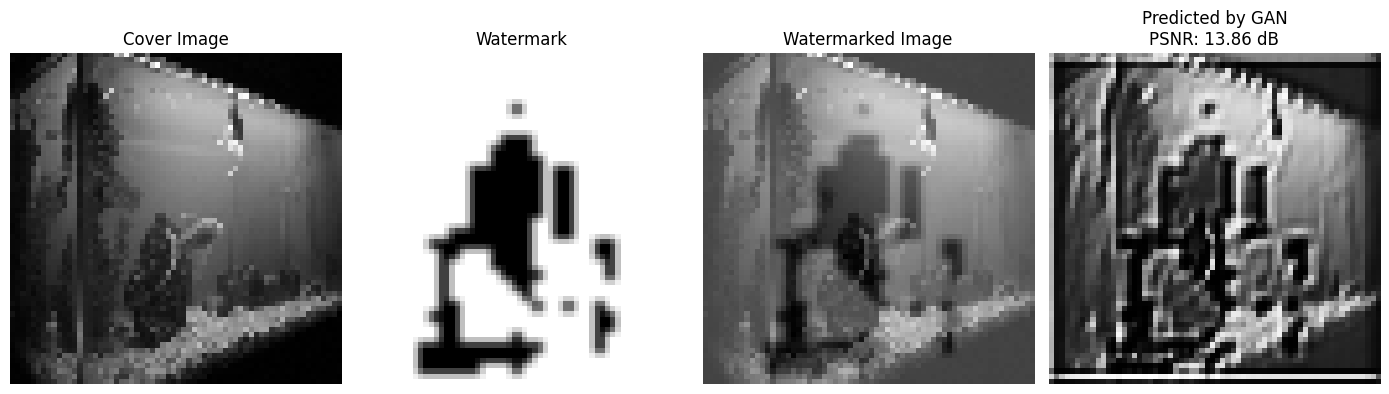

In [83]:
import matplotlib.pyplot as plt
# Visual display
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(cover_img, cmap='gray')
plt.title("Cover Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(watermark_img, cmap='gray')
plt.title("Watermark")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(true_blend, cmap='gray')
plt.title("Watermarked Image")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_blend, cmap='gray')
plt.title(f"Predicted by GAN\nPSNR: {psnr:.2f} dB")
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the generator model
generator.save("cgan_generator_model.h5")

In [88]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import tensorflow as tf

#Evaluate the models - CNN, Xception and cGAN
def evaluate_model_with_time(model, ds, model_type="cnn"):
    mse_list, psnr_list, time_list, ssim_list = [], [], [], []

    for x, y in ds.take(30):  # Limit evaluation to 30 batches
        batch_start = time.time()
        preds = model.predict(x, verbose=0)
        elapsed = (time.time() - batch_start) / preds.shape[0]  # per image

        preds = np.clip(preds, 0, 1)

        for i in range(preds.shape[0]):
            true = y[i].numpy().squeeze()
            pred = preds[i].squeeze()

            # Resize if model is xception
            if model_type == "xception":
                true = tf.image.resize(y[i], [71, 71]).numpy().squeeze()

            # Compute MSE and PSNR
            mse = mean_squared_error(true.flatten(), pred.flatten())
            psnr = 10 * np.log10(1.0 / mse)

            # Compute SSIM
            ssim_score = ssim(true, pred, data_range=1.0)

            # Append metrics
            mse_list.append(mse)
            psnr_list.append(psnr)
            ssim_list.append(ssim_score)
            time_list.append(elapsed * 1000)  # convert to ms

    return (
        np.mean(mse_list),
        np.mean(psnr_list),
        np.mean(time_list),
        np.mean(ssim_list),
    )



In [89]:
cnn_mse, cnn_psnr, cnn_time, cnn_ssim = evaluate_model_with_time(cnn_model, test_image_ds, "cnn")
xception_mse, xception_psnr, xception_time, xception_ssim = evaluate_model_with_time(xception_model, test_ds_x, "xception")
gan_mse, gan_psnr, gan_time, gan_ssim = evaluate_model_with_time(generator, test_image_ds, "gan")

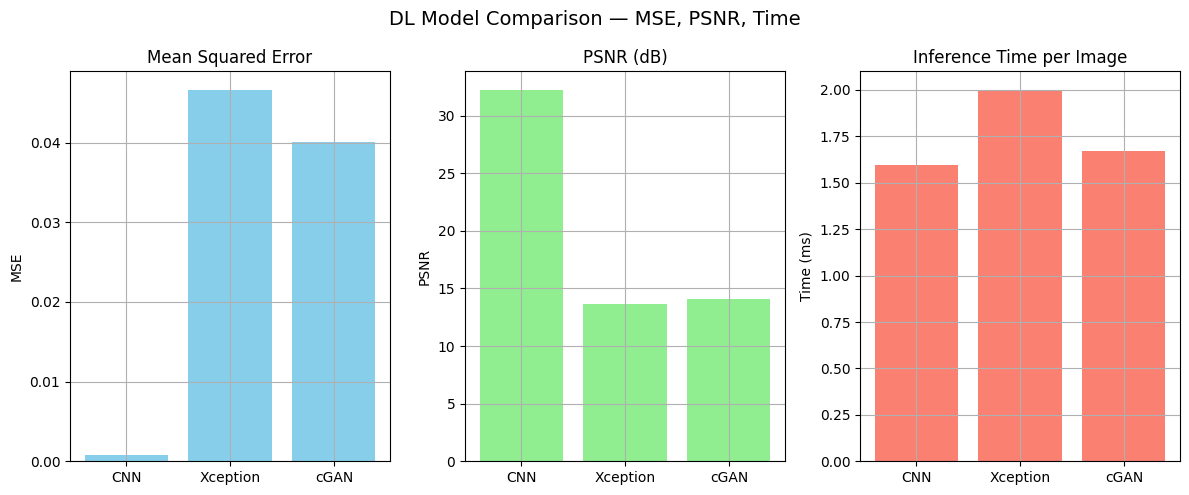

In [90]:
labels = ['CNN', 'Xception', 'cGAN']
mse_values = [cnn_mse, xception_mse, gan_mse]
psnr_values = [cnn_psnr, xception_psnr, gan_psnr]
time_values = [cnn_time, xception_time, gan_time]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(labels, mse_values, color='skyblue')
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.grid(True)

# PSNR
plt.subplot(1, 3, 2)
plt.bar(labels, psnr_values, color='lightgreen')
plt.title("PSNR (dB)")
plt.ylabel("PSNR")
plt.grid(True)

# Time
plt.subplot(1, 3, 3)
plt.bar(labels, time_values, color='salmon')
plt.title("Inference Time per Image")
plt.ylabel("Time (ms)")
plt.grid(True)

plt.suptitle("DL Model Comparison — MSE, PSNR, Time", fontsize=14)
plt.tight_layout()
plt.show()


In [91]:
import pandas as pd

# Create the table
deep_model_metrics = pd.DataFrame({
    "Model": ["CNN", "Xception", "GAN"],
    "MSE": [round(cnn_mse, 4), round(xception_mse, 4), round(gan_mse, 4)],
    "PSNR (dB)": [round(cnn_psnr, 2), round(xception_psnr, 2), round(gan_psnr, 2)],
    "SSIM": [round(cnn_ssim, 4), round(xception_ssim, 4), round(gan_ssim, 4)],
    "Time per Image (ms)": [round(cnn_time, 2), round(xception_time, 2), round(gan_time, 2)]
})

# Set index for a cleaner look
deep_model_metrics.set_index("Model", inplace=True)

# Display
deep_model_metrics


,MSE,PSNR (dB),SSIM,Time per Image (ms)
Model,,,,
CNN,0.0008,32.24,0.9650,1.59
Xception,0.0466,13.69,0.1838,2.00
GAN,0.0401,14.09,0.5661,1.67
